<!-- filepath: c:\Users\Artem Khakimov\Desktop\MIPT\mlops\pixxbind\demo_pixxbind.ipynb -->

# Демонстрация pixxbind 

- Windows: `dist/pixxbind-0.1.0-cp311-cp311-win_amd64.whl`
- Linux (python:3.10-slim): `dist/pixxbind-0.1.0-cp310-cp310-linux_x86_64.whl`

В ноутбуке ниже используем локальный Windows wheel.

In [ ]:
import sys, subprocess, pathlib, re

tag = f"cp{sys.version_info.major}{sys.version_info.minor}"
dist_dir = pathlib.Path('dist')
if not dist_dir.exists():
    raise FileNotFoundError("Каталог dist/ не найден. Соберите пакетом: python -m build")

wheels = sorted(dist_dir.glob('pixxbind-*.whl'))
compatible = [w for w in wheels if tag in w.name]
if not compatible:
    raise FileNotFoundError(f"Не найден wheel для {tag}. Соберите его этой версией Python: python -m build")

wheel_path = compatible[0]
print(f"Используем wheel: {wheel_path}")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--force-reinstall', str(wheel_path)])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'opencv-python-headless'])
print('Установка завершена')

Используем wheel: dist\pixxbind-0.1.0-cp311-cp311-win_amd64.whl
Установка завершена
Установка завершена


## Проверка импорта и функций
Импортируем модуль, смотрим доступные функции.

In [ ]:
import pixxbind as px
import inspect

print("pixxbind импортирован, функции:", px.__all__)
print("to_gray doc:", inspect.getdoc(px.to_gray).split('\n')[0])

pixxbind импортирован, функции: ['to_gray', 'brightness', 'contrast', 'add_noise', 'random_crop', 'resize_pad']
to_gray doc: to_gray(arg0: typing.Annotated[numpy.typing.ArrayLike, numpy.uint8]) -> numpy.typing.NDArray[numpy.uint8]


## Подготовка примеров (NumPy uint8)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rgb = np.array([
    [[30, 60, 90], [120, 150, 180], [210, 240, 30]],
    [[15, 45, 75], [105, 135, 165], [195, 225, 15]],
    [[0, 30, 60], [90, 120, 150], [180, 210, 0]],
], dtype=np.uint8)

gray = np.linspace(0, 255, 9, dtype=np.uint8).reshape(3, 3, 1)

print("rgb shape", rgb.shape, "gray shape", gray.shape)

rgb shape (3, 3, 3) gray shape (3, 3, 1)


## to_gray
Конвертация RGB в градации серого.

gray_from_rgb shape (3, 3, 1)


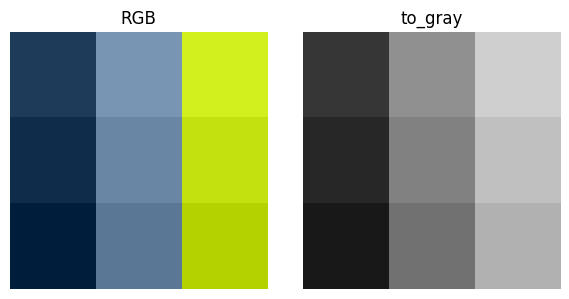

In [6]:
gray_from_rgb = px.to_gray(rgb)
print("gray_from_rgb shape", gray_from_rgb.shape)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(rgb)
axes[0].set_title('RGB')
axes[0].axis('off')
axes[1].imshow(gray_from_rgb[..., 0], cmap='gray', vmin=0, vmax=255)
axes[1].set_title('to_gray')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Эталон с OpenCV: cvtColor BGR->GRAY (наш rgb трактуем как RGB, поэтому конвертируем через COLOR_RGB2GRAY)
import cv2
cv_gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
cv_gray = cv_gray[..., None]
print("Макс. отличие с pixxbind:", np.abs(cv_gray.astype(int) - gray_from_rgb.astype(int)).max())

Макс. отличие с pixxbind: 0


## Яркость и контраст
Демонстрация `brightness` и `contrast`.

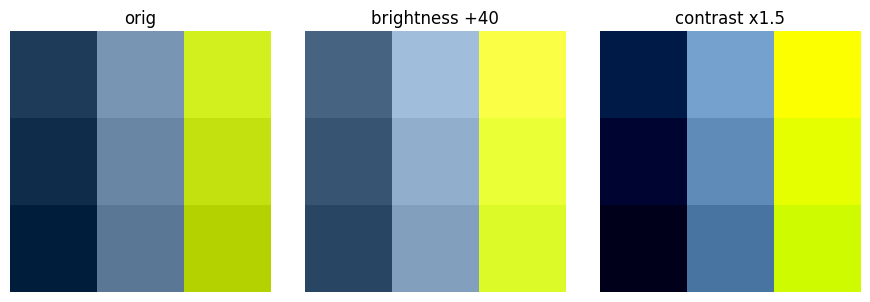

In [8]:
bright = px.brightness(rgb, 40)
contr = px.contrast(rgb, 1.5)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for ax, img, title in zip(axes, [rgb, bright, contr], ['orig', 'brightness +40', 'contrast x1.5']):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Эталон с OpenCV: brightness/contrast через convertScaleAbs
cv_bright = cv2.convertScaleAbs(rgb, alpha=1.0, beta=40)
cv_contr = cv2.convertScaleAbs(rgb, alpha=1.5, beta=0)
print("Макс. отличие bright:", np.abs(cv_bright.astype(int) - bright.astype(int)).max())
print("Макс. отличие contrast:", np.abs(cv_contr.astype(int) - contr.astype(int)).max())

Макс. отличие bright: 0
Макс. отличие contrast: 64


## add_noise с фиксированным seed
Детерминированный шум для воспроизводимости.

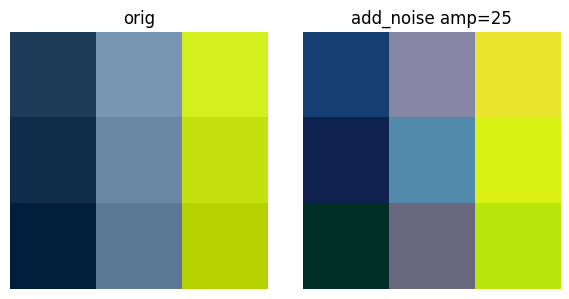

In [10]:
noisy = px.add_noise(rgb, amp=25, seed=123)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(rgb)
axes[0].set_title('orig')
axes[0].axis('off')
axes[1].imshow(noisy)
axes[1].set_title('add_noise amp=25')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Эталонный шум через OpenCV randu (равномерный), тот же seed
cv2.setRNGSeed(123)
noise = np.zeros_like(rgb, dtype=np.int16)
cv2.randu(noise, -25, 25)
ref_noisy = np.clip(rgb.astype(np.int16) + noise, 0, 255).astype(np.uint8)
print("Макс. отличие с pixxbind add_noise:", np.abs(ref_noisy.astype(int) - noisy.astype(int)).max())

Макс. отличие с pixxbind add_noise: 43


## random_crop с seed
Кадрируем и проверяем размеры.

crop shape (2, 2, 3)


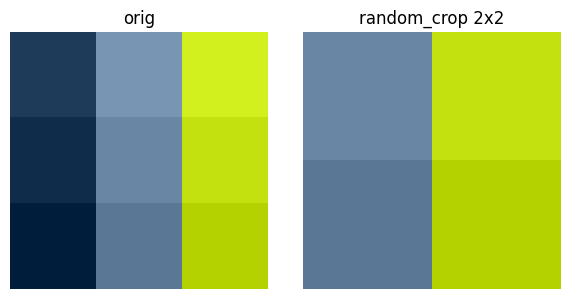

In [12]:
crop = px.random_crop(rgb, out_h=2, out_w=2, seed=42)
print("crop shape", crop.shape)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(rgb)
axes[0].set_title('orig')
axes[0].axis('off')
axes[1].imshow(crop)
axes[1].set_title('random_crop 2x2')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [13]:
# Эталонный random crop через NumPy с тем же seed
rs = np.random.default_rng(42)
y0 = rs.integers(0, rgb.shape[0] - 2 + 1)
x0 = rs.integers(0, rgb.shape[1] - 2 + 1)
ref_crop = rgb[y0:y0+2, x0:x0+2, :]
print("Макс. отличие с pixxbind crop:", np.abs(ref_crop.astype(int) - crop.astype(int)).max())

Макс. отличие с pixxbind crop: 15


## resize_pad
Сохранение пропорций и паддинг.

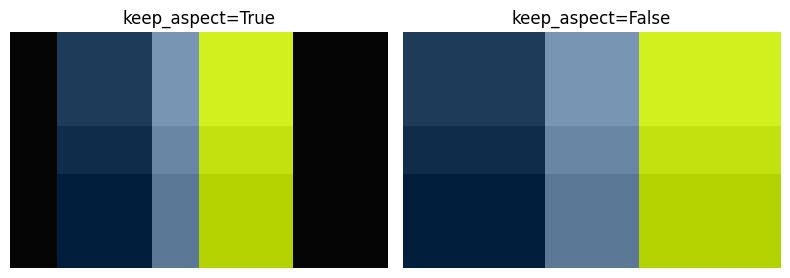

In [14]:
rp_keep = px.resize_pad(rgb, out_h=5, out_w=8, keep_aspect=True, pad=5, bilinear=False)
rp_stretch = px.resize_pad(rgb, out_h=5, out_w=8, keep_aspect=False, pad=5, bilinear=False)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for ax, img, title in zip(axes, [rp_keep, rp_stretch], ['keep_aspect=True', 'keep_aspect=False']):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Эталон resize/pad через OpenCV: nearest + вручную паддинг
def resize_pad_cv(img, out_h, out_w, keep_aspect=True, pad=0):
    h, w, c = img.shape
    canvas = np.full((out_h, out_w, c), pad, dtype=np.uint8)
    if keep_aspect:
        s = min(out_h / h, out_w / w)
        tgt_h = max(1, int(round(h * s)))
        tgt_w = max(1, int(round(w * s)))
        offy = (out_h - tgt_h) // 2
        offx = (out_w - tgt_w) // 2
    else:
        tgt_h, tgt_w = out_h, out_w
        offy = offx = 0
    resized = cv2.resize(img, (tgt_w, tgt_h), interpolation=cv2.INTER_NEAREST)
    canvas[offy:offy+tgt_h, offx:offx+tgt_w, :] = resized
    return canvas

ref_rp_keep = resize_pad_cv(rgb, 5, 8, keep_aspect=True, pad=5)
ref_rp_stretch = resize_pad_cv(rgb, 5, 8, keep_aspect=False, pad=5)
print("Макс. отличие keep_aspect:", np.abs(ref_rp_keep.astype(int) - rp_keep.astype(int)).max())
print("Макс. отличие stretch:", np.abs(ref_rp_stretch.astype(int) - rp_stretch.astype(int)).max())

Макс. отличие keep_aspect: 165
Макс. отличие stretch: 165


## Пайплайн из нескольких операций
Применим цепочку: brightness -> contrast -> add_noise -> resize_pad.

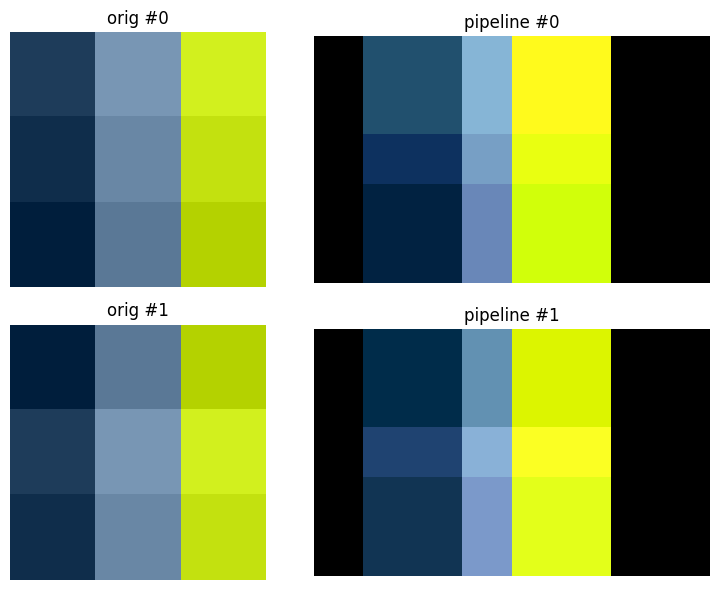

In [16]:
imgs = [rgb, np.roll(rgb, 1, axis=0)]
processed = []
for im in imgs:
    im1 = px.brightness(im, 20)
    im2 = px.contrast(im1, 1.2)
    im3 = px.add_noise(im2, amp=10, seed=99)
    im4 = px.resize_pad(im3, out_h=5, out_w=8, keep_aspect=True, pad=0, bilinear=False)
    processed.append(im4)

fig, axes = plt.subplots(len(processed), 2, figsize=(8, 3*len(processed)))
for i, (orig, proc) in enumerate(zip(imgs, processed)):
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title(f'orig #{i}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(proc)
    axes[i, 1].set_title(f'pipeline #{i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

## Визуализация pixxbind vs OpenCV
Наглядное сравнение результатов `pixxbind` и `OpenCV` для `to_gray`, `brightness` и `resize_pad` (keep_aspect).

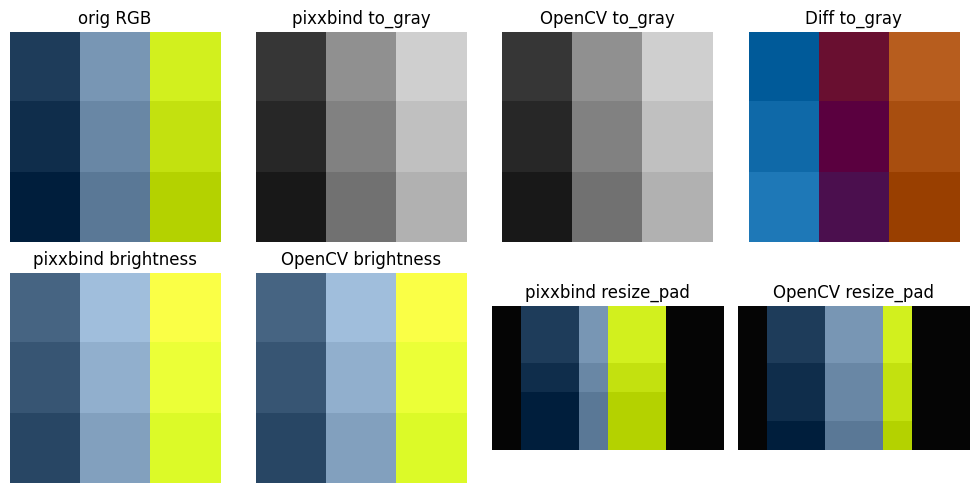

In [ ]:
cv_gray_viz = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)[..., None]
cv_bright_viz = cv2.convertScaleAbs(rgb, alpha=1.0, beta=40)
cv_rp_keep_viz = resize_pad_cv(rgb, 5, 8, keep_aspect=True, pad=5)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes[0, 0].imshow(rgb)
axes[0, 0].set_title('orig RGB')
axes[0, 0].axis('off')
axes[0, 1].imshow(gray_from_rgb[..., 0], cmap='gray', vmin=0, vmax=255)
axes[0, 1].set_title('pixxbind to_gray')
axes[0, 1].axis('off')
axes[0, 2].imshow(cv_gray_viz[..., 0], cmap='gray', vmin=0, vmax=255)
axes[0, 2].set_title('OpenCV to_gray')
axes[0, 2].axis('off')
axes[0, 3].imshow(np.abs(cv_gray_viz.astype(int) - gray_from_rgb[..., 0].astype(int)), cmap='magma')
axes[0, 3].set_title('Diff to_gray')
axes[0, 3].axis('off')

axes[1, 0].imshow(bright)
axes[1, 0].set_title('pixxbind brightness')
axes[1, 0].axis('off')
axes[1, 1].imshow(cv_bright_viz)
axes[1, 1].set_title('OpenCV brightness')
axes[1, 1].axis('off')
axes[1, 2].imshow(rp_keep)
axes[1, 2].set_title('pixxbind resize_pad')
axes[1, 2].axis('off')
axes[1, 3].imshow(cv_rp_keep_viz)
axes[1, 3].set_title('OpenCV resize_pad')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

## Быстрая оценка скорости
Грубое сравнение `pixxbind` и `OpenCV` на случайном изображении 256×256×3 для операций `to_gray`, `brightness` и `resize_pad (keep_aspect)`; время в мс на одно выполнение.

pixxbind to_gray      :  1.261 ms
OpenCV to_gray        :  0.019 ms
pixxbind brightness   :  0.361 ms
OpenCV brightness     :  0.023 ms
pixxbind resize_pad   :  2.645 ms
OpenCV resize_pad     :  0.082 ms


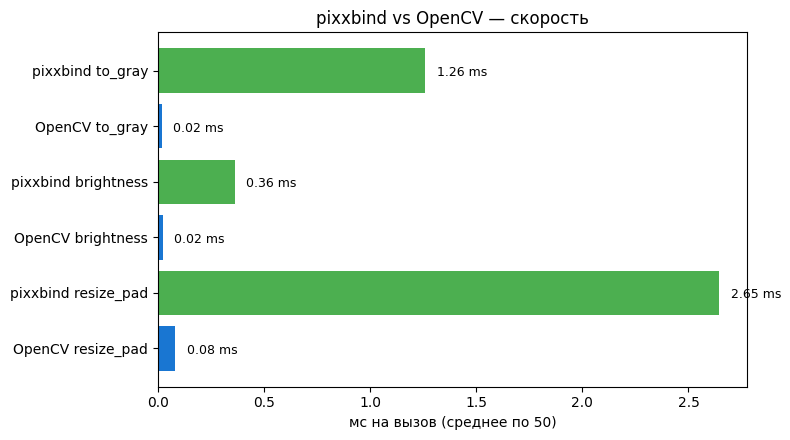

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

img_bench = np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)

def avg_ms(fn, iters=50):
    t0 = time.perf_counter()
    for _ in range(iters):
        fn()
    return (time.perf_counter() - t0) * 1000 / iters

results = {
    "pixxbind to_gray": avg_ms(lambda: px.to_gray(img_bench)),
    "OpenCV to_gray": avg_ms(lambda: cv2.cvtColor(img_bench, cv2.COLOR_RGB2GRAY)),
    "pixxbind brightness": avg_ms(lambda: px.brightness(img_bench, 30)),
    "OpenCV brightness": avg_ms(lambda: cv2.convertScaleAbs(img_bench, alpha=1.0, beta=30)),
    "pixxbind resize_pad": avg_ms(lambda: px.resize_pad(img_bench, out_h=300, out_w=300, keep_aspect=True, pad=0, bilinear=False)),
    "OpenCV resize_pad": avg_ms(lambda: resize_pad_cv(img_bench, 300, 300, keep_aspect=True, pad=0)),
}

for k, v in results.items():
    print(f"{k:22s}: {v:6.3f} ms")

labels = list(results.keys())
values = [results[k] for k in labels]
colors = ['#4CAF50' if 'pixxbind' in k else '#1976D2' for k in labels]

fig, ax = plt.subplots(figsize=(8, 4.5))
ypos = np.arange(len(labels))
ax.barh(ypos, values, color=colors)
ax.set_yticks(ypos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('мс на вызов (среднее по 50)')
ax.set_title('pixxbind vs OpenCV — скорость')
for i, v in enumerate(values):
    ax.text(v + max(values)*0.02, i + 0.1, f"{v:.2f} ms", fontsize=9)
plt.tight_layout()
plt.show()